In [ ]:
import numpy as np

from sklearn.neural_network import MLPRegressor

from Chempy.parameter import ModelParameters

import sbi.utils as utils
from sbi.inference.base import infer
from sbi.analysis import pairplot

import ili

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
import pickle

# Train Neural Network to simulate Chempy

In [ ]:
# ------ Load & prepare the data ------

# --- Load in training data ---
path_training = '../ChempyMulti/tutorial_data/TNG_Training_Data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = '../ChempyMulti/tutorial_data/TNG_Test_Data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)


# --- Normalize the data ---
x_mean, x_std = train_x.mean(axis=0), train_x.std(axis=0)
y_mean, y_std = train_y.mean(axis=0), train_y.std(axis=0)


def normalize_data(x, y, x_mean=x_mean, x_std=x_std, y_mean=y_mean, y_std=y_std):
    x = (x - x_mean) / x_std
    y = (y - y_mean) / y_std

    return x, y


train_x, train_y = normalize_data(train_x, train_y)
val_x, val_y     = normalize_data(val_x, val_y)


# add time squared as parameter
def add_time_squared(x):
    time_squared = np.array([x.T[-1]**2]).T
    if len(x.shape) == 1:
        return np.concatenate((x, time_squared))
    elif len(x.shape) == 2:
        return np.concatenate((x, time_squared), axis=1)


train_x = add_time_squared(train_x)
val_x = add_time_squared(val_x)

In [ ]:
# ----- Train the neural network -----

# --- Define the neural network ---
def single_regressor(x, y, neurons=40, epochs=3000, verbose=False):
    """Return out-of-sample score for a given number of neurons for one element"""
    model = MLPRegressor(solver='adam', alpha=0.001, max_iter=epochs, learning_rate='adaptive', tol=1e-13,
                         hidden_layer_sizes=(neurons,), activation='tanh', verbose=verbose,
                         shuffle=True, early_stopping=True)

    model.fit(x, y)

    model_pred = model.predict(x)
    score = np.mean((model_pred-y)**2.)
    diff = np.abs(y-model_pred)

    w0, w1 = model.coefs_
    b0, b1 = model.intercepts_

    return score, diff, [w0, w1, b0, b1]


# --- Train the neural network ---
# Train an independent neural network for each element and save the weights
output = []
neurons = 40
for el_i, el in enumerate(elements):
    print("Running net %d of %d" % (el_i + 1, len(elements)))
    o = single_regressor(train_x, train_y[:, el_i], neurons=neurons, epochs=3000, verbose=False)
    print("Score for element %s is %.3f" % (el, o[0]))
    output.append(o)


# --- Save the neural network outputs ---
scores = [score for score, _, _ in output]
diffs = [diff for _, diff, _ in output]
coeffs = [co for _, _, co in output]

w0 = np.hstack([co[0] for co in coeffs])
b0 = np.hstack([co[2] for co in coeffs])
b1 = np.hstack([co[3] for co in coeffs])

# Read in w1 vector into sparse structure
w1 = np.zeros([w0.shape[1], b1.shape[0]])
assert neurons == w0.shape[1] / len(coeffs)
for i in range(len(coeffs)):
    w1[int(neurons * i):int(neurons * (i + 1)), i] = coeffs[i][1][:, 0]

In [ ]:
# --- Save the weights and normalization parameters ---
# Save output
np.savez('data/tutorial_weights.npz',
         w0=w0, w1=w1, b0=b0, b1=b1,
         in_mean=x_mean, in_std=x_std, out_mean=y_mean, out_std=y_std,
         activation='tanh', neurons=neurons)


# Train SBI

In [ ]:
# ----- Load the Network -----
# Load network weights trained in train_chempyNN.py
x = np.load('data/tutorial_weights.npz')

w0 = x['w0']
w1 = x['w1']
b0 = x['b0']
b1 = x['b1']
in_mean = x['in_mean']
in_std = x['in_std']
out_mean = x['out_mean']
out_std = x['out_std']
activation = x['activation']
neurons = x['neurons']

In [ ]:
# ----- Set-up the Simulator -----
def add_time_squared(x):
    time_squared = np.array([x.T[-1]**2]).T
    if len(x.shape) == 1:
        return np.concatenate((x, time_squared))
    elif len(x.shape) == 2:
        return np.concatenate((x, time_squared), axis=1)


def simulator_NN(in_par):
    in_par = (in_par - in_mean) / in_std
    in_par = add_time_squared(in_par)

    l1 = np.matmul(in_par, w0) + b0
    l2 = np.matmul(np.tanh(l1), w1) + b1

    return l2 * out_std + out_mean

In [ ]:
# ----- Set-up priors -----
a = ModelParameters()
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

In [ ]:
# ----- sbi setup -----
num_sim = 100000
method = 'SNPE' #SNPE or SNLE or SNRE

start = t.time()
posterior = infer(
    simulator_NN,
    combined_priors,
    method=method,
    num_simulations=num_sim)

print(f'Time taken to train the posterior with {num_sim} samples: {round(t.time() - start, 4)}s')

In [ ]:
# ----- Save the posterior -----
with open("data/posterior_SNPE.pickle", "wb") as f:
    pickle.dump(posterior, f)


# Train ili

In [ ]:
loader = ili.dataloaders.NumpyLoader(train_x, train_y)             # Create a data loader

trainer = ili.inference.InferenceRunner.load(
    backend = 'sbi',
    engine='NPE',                # Choose a backend and inference engine (here, Neural Posterior Estimation)
    prior = combined_priors,    # Define a prior
    # Define a neural network architecture (here, MAF)
    nets = [ili.utils.load_nde_sbi(engine='NPE', model='maf')]
)

start = t.time()
posterior_ili, _ = trainer(loader)                  # Run training to map data -> parameters
print(f'Time taken to train the posterior: {round(t.time() - start, 4)}s')

In [ ]:
samples = posterior.sample(                     # Generate 1000 samples from the posterior for input x[0]
  x=train_x[0], sample_shape=(10,)
)

# Evaluate the posterior

In [1]:
import numpy as np
import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
import pickle
from sbi.analysis import pairplot

from Chempy.parameter import ModelParameters
import sbi.utils as utils


# ------ Load & prepare the data ------

# --- Load in training data ---
path_training = '../ChempyMulti/tutorial_data/TNG_Training_Data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = '../ChempyMulti/tutorial_data/TNG_Test_Data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)


# --- Normalize the data ---
x_mean, x_std = train_x.mean(axis=0), train_x.std(axis=0)
y_mean, y_std = train_y.mean(axis=0), train_y.std(axis=0)


def normalize_data(x, y, x_mean=x_mean, x_std=x_std, y_mean=y_mean, y_std=y_std):
    x = (x - x_mean) / x_std
    y = (y - y_mean) / y_std

    return x, y


train_x, train_y = normalize_data(train_x, train_y)
val_x, val_y     = normalize_data(val_x, val_y)


# add time squared as parameter
def add_time_squared(x):
    time_squared = np.array([x.T[-1]**2]).T
    if len(x.shape) == 1:
        return np.concatenate((x, time_squared))
    elif len(x.shape) == 2:
        return np.concatenate((x, time_squared), axis=1)


train_x = add_time_squared(train_x)
val_x = add_time_squared(val_x)


# ----- Load the Network -----
# Load network weights trained in train_chempyNN.py
x = np.load('data/tutorial_weights.npz')

w0 = x['w0']
w1 = x['w1']
b0 = x['b0']
b1 = x['b1']
in_mean = x['in_mean']
in_std = x['in_std']
out_mean = x['out_mean']
out_std = x['out_std']
activation = x['activation']
neurons = x['neurons']


# ----- Set-up the Simulator -----
def simulator_NN(in_par):
    in_par = (in_par - in_mean) / in_std
    in_par = add_time_squared(in_par)

    l1 = np.matmul(in_par, w0) + b0
    l2 = np.matmul(np.tanh(l1), w1) + b1

    return l2 * out_std + out_mean


# ----- Set-up priors -----
a = ModelParameters()
labels=[a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

/Users/bguenes/miniconda3/envs/master_chempy_multi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ----- Load the posterior -----
with open("data/posterior_SNPE.pickle", "rb") as f:
    posterior = pickle.load(f)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:01<00:00, 8192.08it/s]


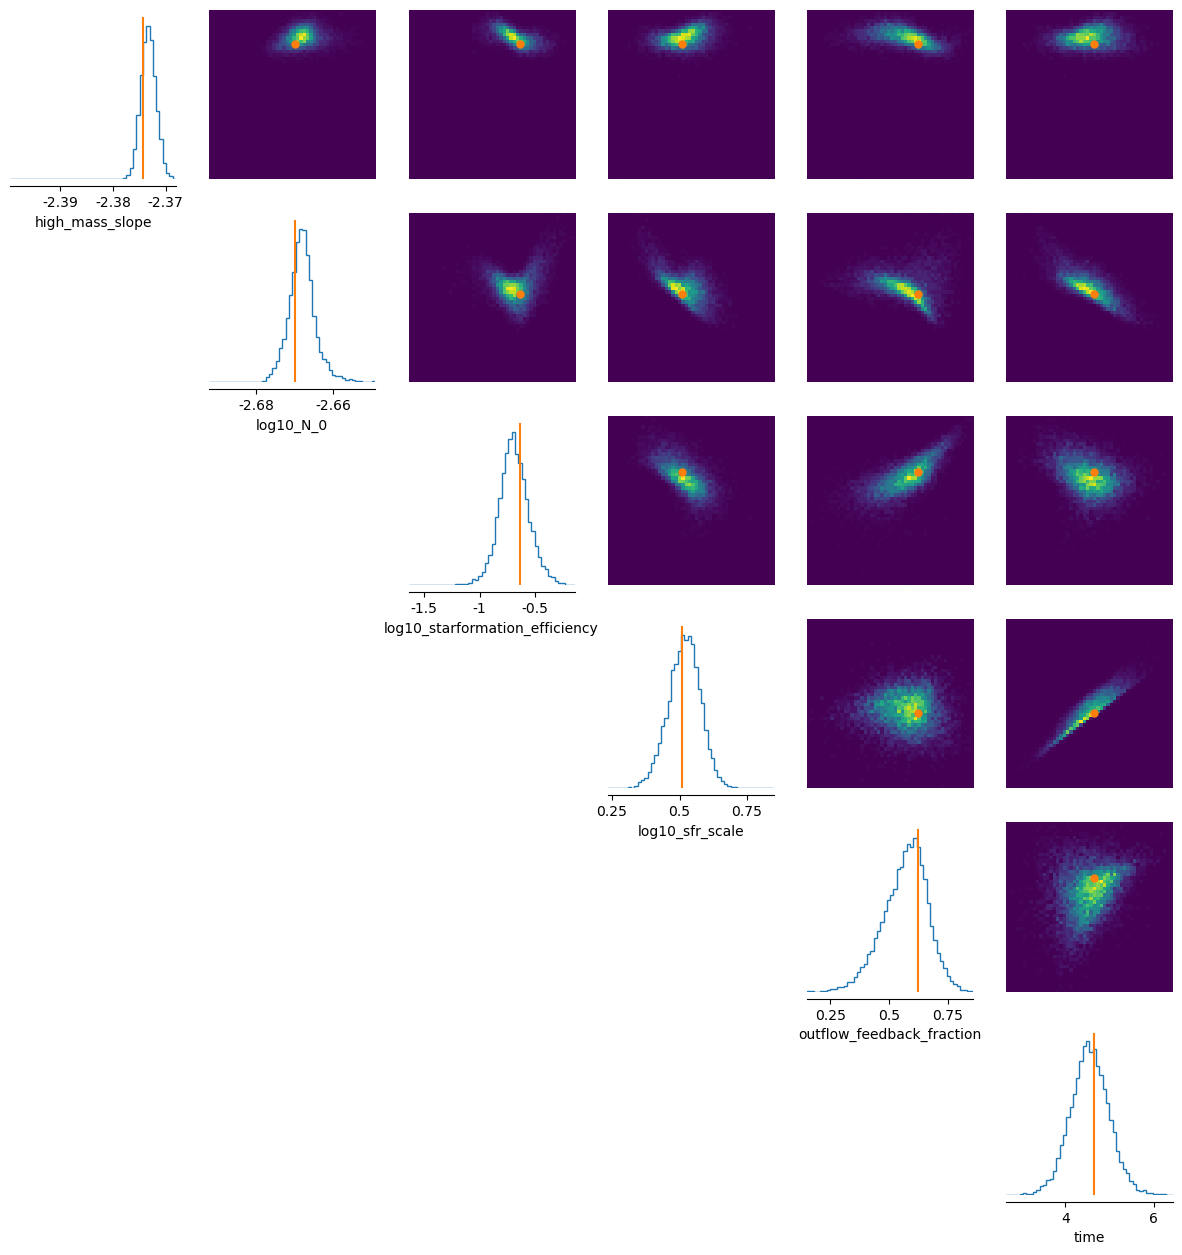

In [4]:
# ----- Evaluate the posterior -----
# ----- Simulate data -----
prior = combined_priors.sample((1,))
simulated_data = simulator_NN(prior)

posterior_samples = posterior.sample((10000,), x=simulated_data)
_ = pairplot(posterior_samples, figsize=(15, 15), points=prior, labels=labels)

Drawing 10000 posterior samples: 11959it [00:02, 5315.46it/s]                          


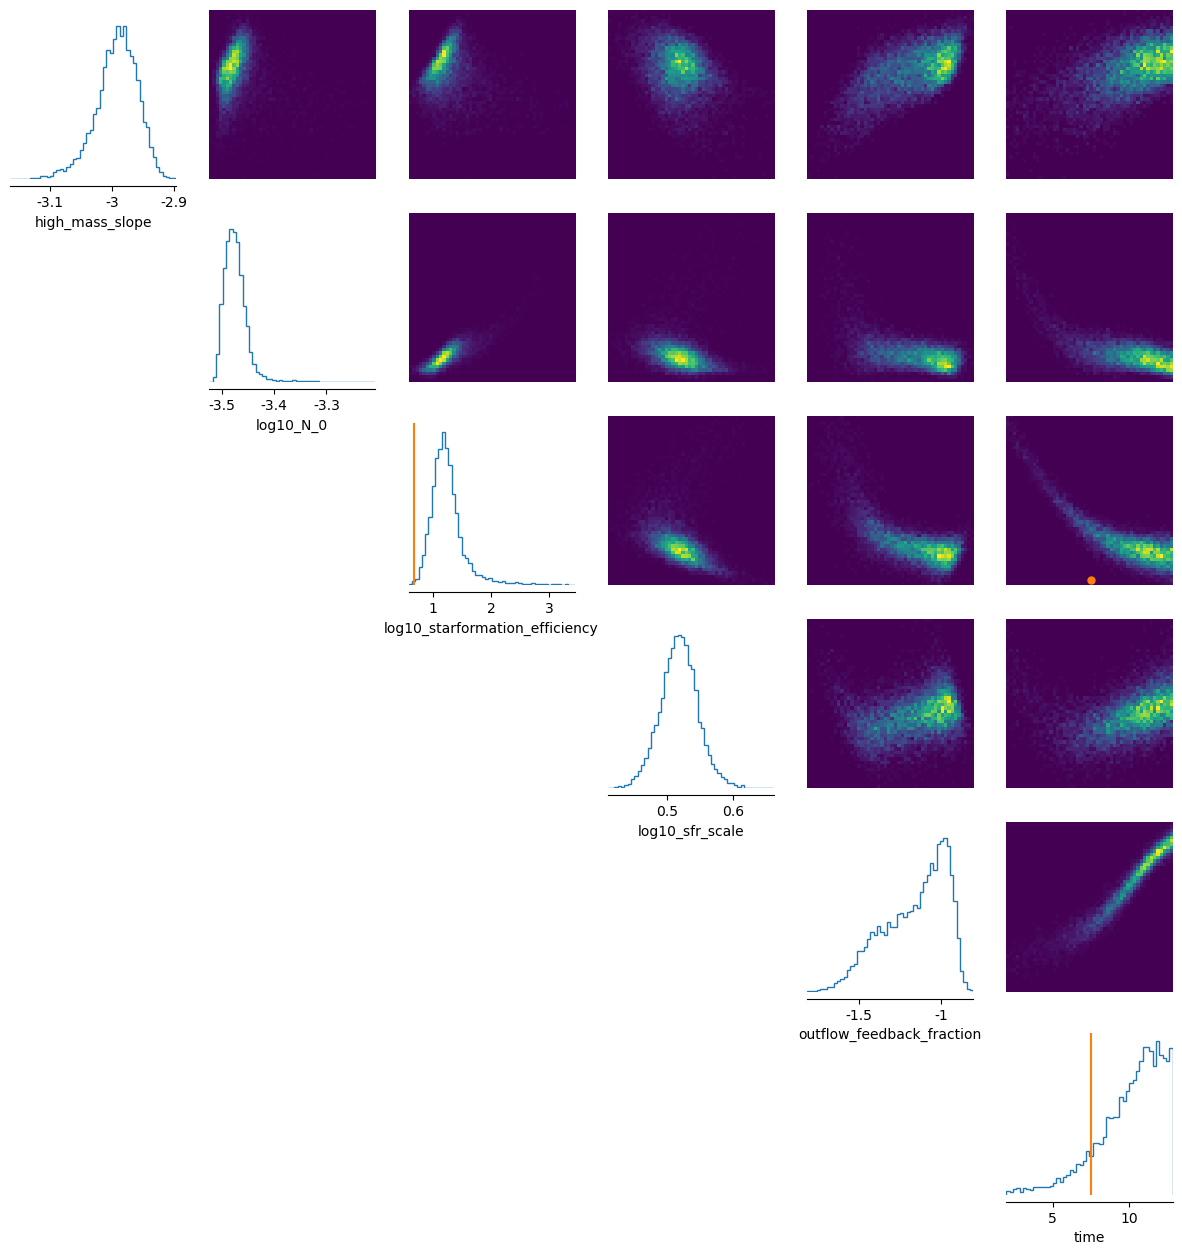

In [5]:
# ----- Evaluate the posterior -----
# evaluation data
index = 0
x = val_x[index][:-1]*x_std + x_mean
y = val_y[index]

posterior_samples = posterior.sample((10000,), x=y)
_ = pairplot(posterior_samples, figsize=(15, 15), points=x, labels=labels)